## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import adam_v2, adagrad_v2, adadelta_v2, sgd_experimental, rmsprop_v2
# from keras.optimizers import Adam, Adagrad, Adadelta, SGD, RMSprop
from keras.layers import Dense, Dropout, Activation, Conv2D
from keras.layers import Flatten, MaxPool2D, MaxPooling2D, BatchNormalization
%matplotlib inline

In [2]:
path = "/content/drive/MyDrive/Dataset_BUSI_with_GT/"
imagepatches = glob("/content/drive/MyDrive/Dataset_BUSI_with_GT/**/*).png",recursive=True)
# for filename in imagepatches[0:10]:
#   print(filename)

## Processing Data

In [3]:
import random

class0 = []
class1 = []
class2 = []

for filename in imagepatches:
  if filename.find("normal") != -1:
    class0.append(filename)
  elif filename.find("malignant") != -1:
    class1.append(filename)
  else:
    class2.append(filename)

#randomizing the values
sample_class0 = random.sample(class0,len(class0))
sample_class1 = random.sample(class1,len(class1))
sample_class2 = random.sample(class2,len(class2))

In [4]:
# #for image resolution 50
# from matplotlib.image import imread
# import cv2

# def get_image_arrays(data,label,size=(50,50)):
#   img_arrays = []
#   for i in data:
#     if i.endswith(".png"):
#       img = cv2.imread(i,cv2.IMREAD_COLOR)
#       img_sized = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
#       img_arrays.append([img_sized,label])
#   return img_arrays

# class0_array = get_image_arrays(sample_class0,0)
# class1_array = get_image_arrays(sample_class1,1)
# class2_array = get_image_arrays(sample_class2,2)

In [5]:
#for image resoltuion 128
from matplotlib.image import imread
import cv2

def get_image_arrays(data,label,size=(50,50)):
  img_arrays = []
  for i in data:
    if i.endswith(".png"):
      img = cv2.imread(i,cv2.IMREAD_COLOR)
      img_sized = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
      img_arrays.append([img_sized,label])
  return img_arrays

class0_array_128 = get_image_arrays(sample_class0,0,(128,128))
class1_array_128 = get_image_arrays(sample_class1,1,(128,128))
class2_array_128 = get_image_arrays(sample_class2,2,(128,128))

In [6]:
import random
combined_data = np.concatenate((class0_array_128,class1_array_128))
combined_data = np.concatenate((combined_data,class2_array_128))

random.seed(42)
random.shuffle(combined_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
def combined_data_fn(combined_data, shape = (-1,128,128,3)):
  X = []
  y = []
  for features,label in combined_data:
    X.append(features)
    y.append(label)
  X = np.array(X).reshape(-1,128,128,3)
  print(X.shape)
  return X,y

X, y = combined_data_fn(combined_data)

(780, 128, 128, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(702, 128, 128, 3) (702, 3) (78, 128, 128, 3) (78, 3)


## Training

In [27]:
# from tensorflow.keras.models import Sequential

strategy = tf.distribute.MirroredStrategy()
def create_model():
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', input_shape = (128,128,3)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation = "softmax"))
  adam = adam_v2.Adam(learning_rate=0.0001)

  optimizer = rmsprop_v2.RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

  return model

with strategy.scope():
  model = create_model()


history = model.fit(X_train, y_train,validation_data = (X_val,y_val), batch_size = 1, epochs = 30, 
          verbose = 2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


702/702 - 8s - loss: 3.5300 - accuracy: 0.4786 - val_loss: 0.9878 - val_accuracy: 0.6154 - 8s/epoch - 12ms/step
Epoch 2/30
702/702 - 4s - loss: 0.8976 - accuracy: 0.6097 - val_loss: 0.7768 - val_accuracy: 0.7051 - 4s/epoch - 6ms/step
Epoch 3/30
702/702 - 4s - loss: 0.7299 - accuracy: 0.7051 - val_loss: 0.6419 - val_accuracy: 0.7564 - 4s/epoch - 6ms/step
Epoch 4/30
702/702 - 4s - loss: 0.5356 - accuracy: 0.8048 - val_loss: 0.4998 - val_accuracy: 0.8077 - 4s/epoch - 6ms/step
Epoch 5/30
702/702 - 4s - loss: 0.4547 - accuracy: 0.8390 - val_loss: 0.4055 - val_accuracy: 0.7821 - 4s/epoch - 6ms/step
Epoch 6/30
702/702 - 4s - loss: 0.3274 - accuracy: 0.8860 - val_loss: 0.3432 - val_accuracy: 0.8974 - 4s/epoch - 6ms/step
Epoch 7/30
702/702 - 4s - loss: 0.2639 - accuracy: 0.9117 - val_loss: 0.3384 - val_accuracy: 0.8590 - 4s/epoch - 6ms/step
Epoch 8/30
702/702 - 4s - loss: 0.2045 - accuracy: 0.9387 - val_loss: 0.2562 - val_accuracy: 0.8718 - 4s/epoch - 6ms/step
Epoch 9/30
702/702 - 4s - loss: 0.

In [ ]:
# from tensorflow.keras.models import Sequential

strategy = tf.distribute.MirroredStrategy()
def create_model():
  model = Sequential()
  model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,3)))
  model.add(Conv2D(32, kernel_size=3, activation='relu'))
  model.add(Flatten())
  model.add(Dense(3, activation="softmax"))
  adam = adam_v2.Adam(learning_rate=0.0001)
  model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

  return model

with strategy.scope():
  model = create_model()

history = model.fit(X_train, y_train,
                    validation_data = (X_val,y_val),
                    epochs = 30,
                    verbose = 2)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      18464     
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 3)                 1476099   
                                                                 
Total params: 1,496,355
Trainable params: 1,496,355
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.models import Sequential, Model
model = Model(model.input, outputs=[model.get_layer("conv2d_1").output, model.get_layer("dense").output])

In [15]:
test1 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (9).png",cv2.IMREAD_COLOR)
test2 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (10).png",cv2.IMREAD_COLOR)
test3 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (33).png",cv2.IMREAD_COLOR)
test4 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (31).png",cv2.IMREAD_COLOR)
test5 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (9).png",cv2.IMREAD_COLOR)
test6 = cv2.imread("/content/drive/MyDrive/Dataset_BUSI_with_GT/normal/normal (45).png",cv2.IMREAD_COLOR)
img_sized1  = cv2.resize(test1, (128,128), interpolation=cv2.INTER_LINEAR)
img_sized2  = cv2.resize(test2, (128,128), interpolation=cv2.INTER_LINEAR)
img_sized3  = cv2.resize(test3, (128,128), interpolation=cv2.INTER_LINEAR)
img_sized4  = cv2.resize(test4, (128,128), interpolation=cv2.INTER_LINEAR)
img_sized5  = cv2.resize(test5, (128,128), interpolation=cv2.INTER_LINEAR)
img_sized6  = cv2.resize(test6, (128,128), interpolation=cv2.INTER_LINEAR)

In [17]:
conv_output = model.get_layer("conv2d_1").output
pred_ouptut = model.get_layer("dense").output

In [18]:
t_image1 = img_sized1.reshape(1,128,128,3)
t_image2 = img_sized2.reshape(1,128,128,3)
t_image3 = img_sized3.reshape(1,128,128,3)
t_image4 = img_sized4.reshape(1,128,128,3)
t_image5 = img_sized5.reshape(1,128,128,3)
t_image6 = img_sized6.reshape(1,128,128,3)

In [19]:
conv1, pred1 = model.predict(t_image1)
conv2, pred2 = model.predict(t_image2)
conv3, pred3 = model.predict(t_image3)
conv4, pred4 = model.predict(t_image4)
conv5, pred5 = model.predict(t_image5)
conv6, pred6 = model.predict(t_image6)
print(np.argmax(pred1),np.argmax(pred2),np.argmax(pred3),np.argmax(pred4),np.argmax(pred5),np.argmax(pred6))

0 1 1 1 0 0


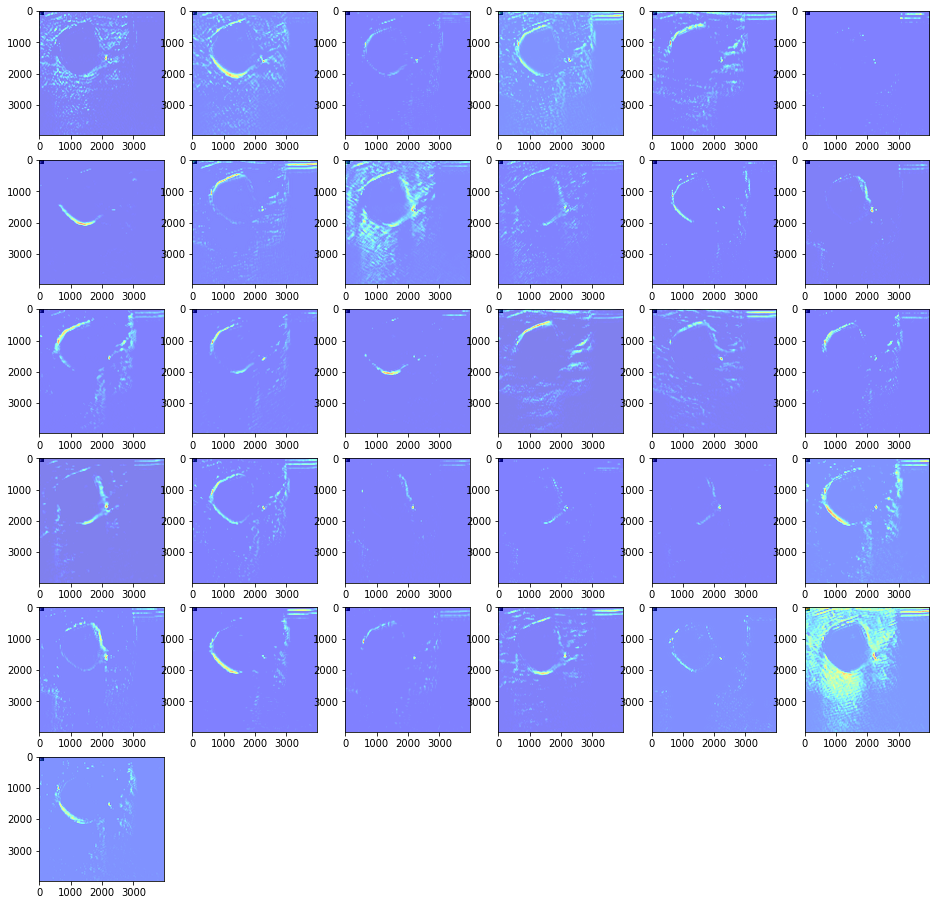

In [20]:
#heatmap of last convolutional layer - conv2d_5 (Conv2D) (None, 124, 124, 32)
from scipy.ndimage import zoom
scale = 128/4
plt.figure(figsize=(16, 16))
for i in range(31):
    plt.subplot(6, 6, i + 1)
    plt.imshow(t_image1[0])
    plt.imshow(zoom(conv1[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.5)

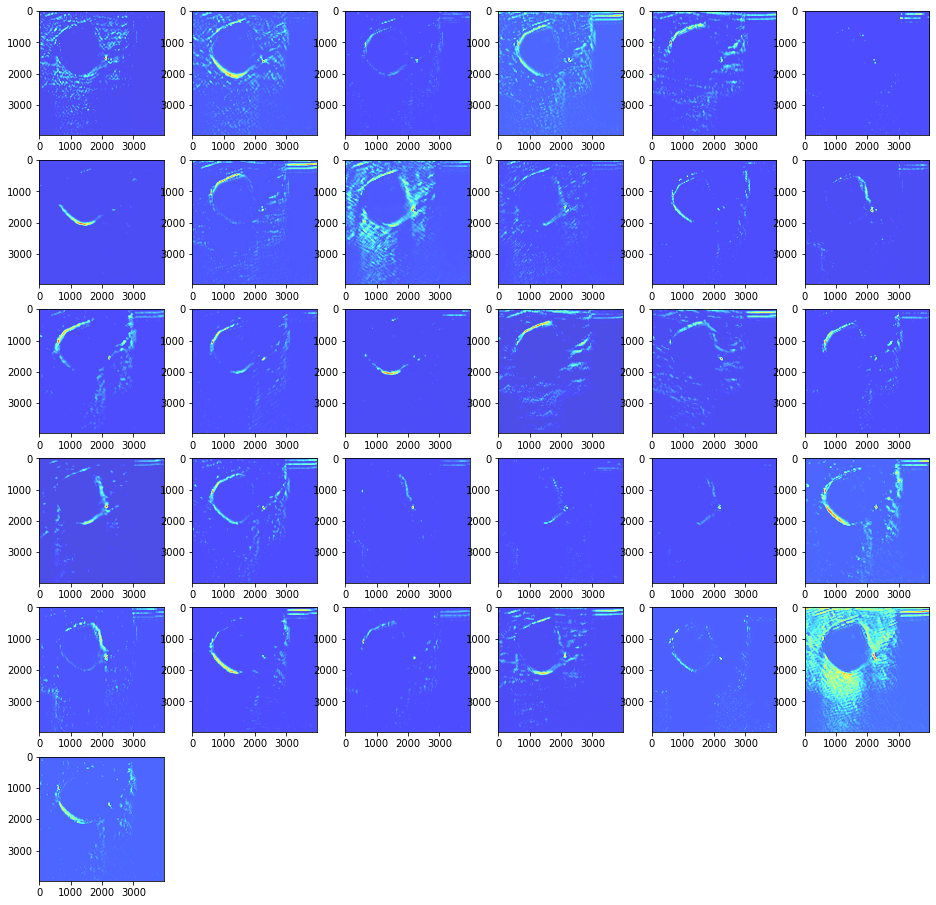

In [22]:
from scipy.ndimage import zoom
scale = 128/4
plt.figure(figsize=(16, 16))
for i in range(31):
    plt.subplot(6, 6, i + 1)
    # plt.imshow(t_image[0])
    plt.imshow(zoom(conv1[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.7)

In [24]:
#heatmap generation
target = np.argmax(pred1, axis=1).squeeze()
w, b = model.get_layer("dense").weights
weights = w[:, target].numpy().reshape(124,124,32)
heatmap = tf.reduce_mean(tf.multiply(weights, conv1.squeeze()), axis=-1)

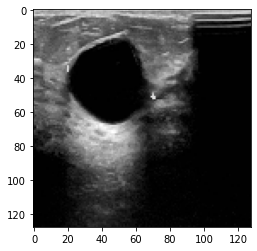

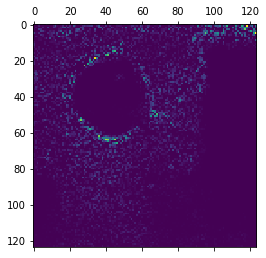

In [25]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
# heatmap = heatmap.reshape((8, 8))
plt.imshow(t_image1[0])
plt.matshow(heatmap)
plt.show()